# Energy consumption

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import helpers as h
from scipy.signal import correlate, find_peaks

In [2]:
data_path = "../results/energy_consumption/"
encryption_methods = ["ASCON", "masked_ASCON", "AES-GCM", "NONE"]
intervals = [100, 100, 100, 100, 1000, 1000, 1000, 1000, 6000, 6000, 6000, 6000]

In [3]:

# Read the data
path = os.path.join(data_path, "ascon1-12", "Main current - Arc.csv")
orig_df = pd.read_csv(
    path,
    engine="pyarrow",               # still OK in pandas ≥2.0
    usecols=["Value", "Timestamp"], # limit to those two columns
    dtype={"Value": "float32"},     # optional speed/memory tweak
)


In [4]:
orig_df

,Value,Timestamp
0,-1.380000e-07,0.00000
1,-4.800000e-08,0.00025
2,-2.650000e-07,0.00050
3,-1.520000e-07,0.00075
4,-1.990000e-07,0.00100
...,...,...
124519343,3.828500e-02,31129.83575
124519344,3.836700e-02,31129.83600
124519345,3.836700e-02,31129.83625
124519346,3.836700e-02,31129.83650


In [5]:
boot_time = 8
df = orig_df.iloc[boot_time*4000:]
df = df.iloc[::4].reset_index(drop=True)


In [6]:
df

,Value,Timestamp
0,0.038943,8.000
1,0.038861,8.001
2,0.038861,8.002
3,0.038778,8.003
4,0.038943,8.004
...,...,...
31121832,0.038367,31129.832
31121833,0.038285,31129.833
31121834,0.038285,31129.834
31121835,0.038285,31129.835


<Axes: title={'center': 'ASCON 1-12'}, xlabel='Time (s)', ylabel='Current (A)'>

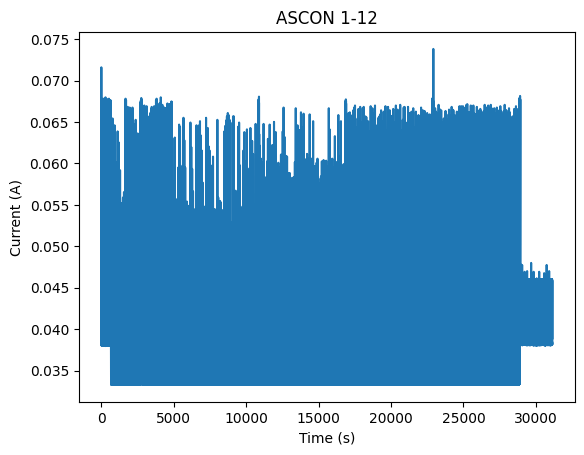

In [7]:
df.plot(
    x="Timestamp",
    y="Value",
    title="ASCON 1-12",
    xlabel="Time (s)",
    ylabel="Current (A)",
    legend=False,
)

In [8]:
def split_and_remove_separators(
    df,
    value_col,
    templates,
    fs,
    min_interval_s=30,
    corr_thresh=0.6,
    combine="max"    # "max" or "sum"
):
    """
    1) Cross-correlate each template in `templates` with df[value_col].
    2) Combine their normalized correlations by 'max' or 'sum'.
    3) Find peaks separated by ≥ min_interval_s seconds.
    4) Excise ±half-template-length around each peak.
    5) Drop the trailing noise chunk, return the 12 real recordings.
    """
    # (1) extract signal
    signal = df[value_col].values.astype(float)

    # (2) correlate each template
    corrs = []
    for templ in templates:
        t = templ.astype(float)
        c = correlate(signal - signal.mean(),
                      t      - t.mean(),
                      mode="same",
                      method="fft")
        c /= np.max(np.abs(c))
        corrs.append(c)

    # (3) combine correlations
    if combine == "sum":
        combo = np.sum(corrs, axis=0)
    else:  # "max"
        combo = np.maximum.reduce(corrs)

    # (4) detect peaks
    distance = int(min_interval_s * fs)
    peaks, _ = find_peaks(combo, height=corr_thresh, distance=distance)

    # drop any in the first second (boot)
    boot_cutoff = int(1.0 * fs)
    peaks = peaks[peaks > boot_cutoff]

    # (5) figure half-pattern length (use the longest template)
    half_len = max(len(t) for t in templates) // 2

    # carve out recordings excluding each blob
    recs = []
    prev = 0
    for p in peaks:
        recs.append(df.iloc[prev : max(0, p - half_len)].reset_index(drop=True))
        prev = min(len(df), p + half_len)
    # last chunk too
    recs.append(df.iloc[prev:].reset_index(drop=True))

    # drop the trailing noise (13th)
    recordings = recs[:-1]

    # (6) report
    def fmt(t):
        m = int(t // 60)
        s = t % 60
        return f"{m:02d}:{s:06.3f}"

    for i, rec in enumerate(recordings, 1):
        st, en = rec.Timestamp.iloc[0], rec.Timestamp.iloc[-1]
        print(f"Recording {i}: {len(rec)} rows, {fmt(st)} → {fmt(en)}")

    return recordings


In [9]:
def time_to_idx(df, t):
    return df.index[df['Timestamp'] >= t][0]

fs = 1 / 0.001  # if original was 4 kHz (0.00025s), every 4th → 1 kHz → 0.001 s sample period

# the two known pattern times (in seconds)
t1 = 1*60 + 49 # 109 s
t2 = 2*60 + 55 # 175 s

idx1 = time_to_idx(df, t1)
idx2 = time_to_idx(df, t2)

temp1 = df.Value.iloc[idx1:idx2].values

t3 = 4*60 + 35
t4 = 5*60 + 41

idx3 = time_to_idx(df, t3)
idx4 = time_to_idx(df, t4)


temp2 = df.Value.iloc[idx3:idx4].values

t5 = 27*60 + 42
t6 = 28*60 + 48

idx5 = time_to_idx(df, t5)
idx6 = time_to_idx(df, t6)

temp3 = df.Value.iloc[idx5:idx6].values



<Axes: title={'center': 'ASCON 1-12'}, xlabel='Time (s)', ylabel='Current (A)'>

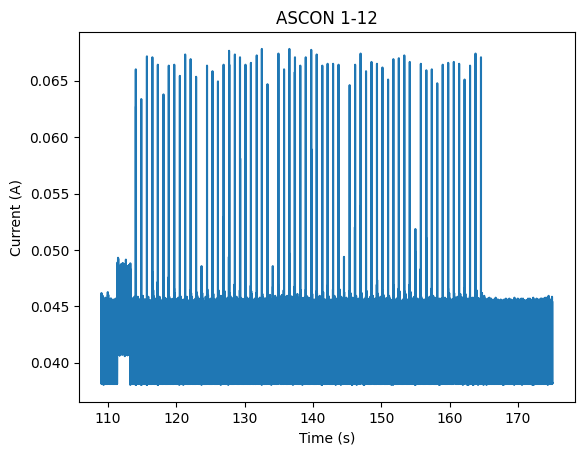

In [10]:
df.iloc[idx1:idx2].plot(
    x="Timestamp",
    y="Value",
    title="ASCON 1-12",
    xlabel="Time (s)",
    ylabel="Current (A)",
    legend=False,
)

<Axes: title={'center': 'ASCON 1-12'}, xlabel='Time (s)', ylabel='Current (A)'>

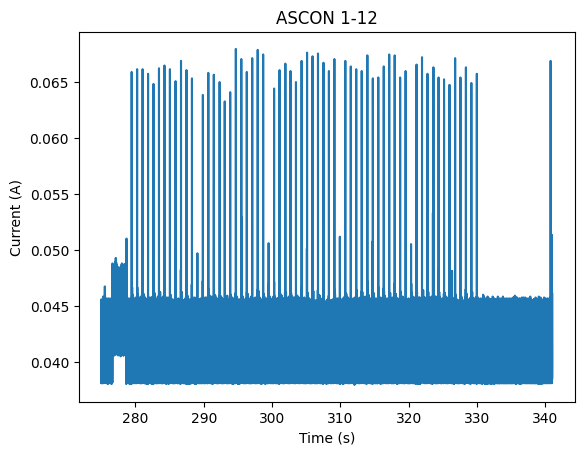

In [11]:
df.iloc[idx3:idx4].plot(
    x="Timestamp",
    y="Value",
    title="ASCON 1-12",
    xlabel="Time (s)",
    ylabel="Current (A)",
    legend=False,
)

<Axes: title={'center': 'ASCON 1-12'}, xlabel='Time (s)', ylabel='Current (A)'>

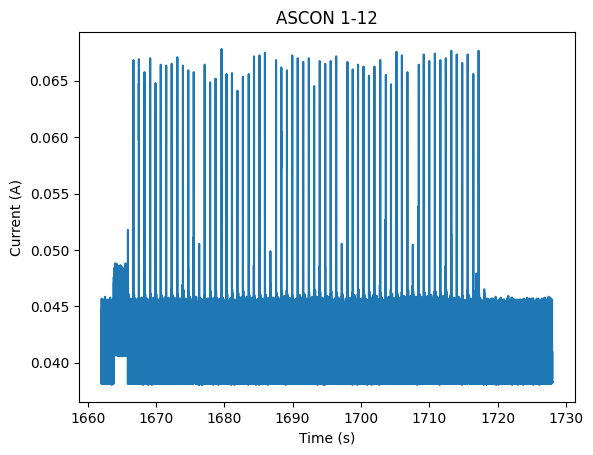

In [12]:
df.iloc[idx5:idx6].plot(
    x="Timestamp",
    y="Value",
    title="ASCON 1-12",
    xlabel="Time (s)",
    ylabel="Current (A)",
    legend=False,
)

In [13]:
segments = split_and_remove_separators(
    df,
    value_col="Value",
    templates=[temp1, temp2, temp3],
    fs=fs,
    min_interval_s=100,    # your patterns are minutes apart
    corr_thresh=0.6,
    combine="max"
)

Recording 1: 101000 rows, 00:08.000 → 01:48.999
Recording 2: 100000 rows, 02:55.000 → 04:34.999
Recording 3: 101817 rows, 05:41.000 → 07:22.816
Recording 4: 96410 rows, 08:28.817 → 10:05.226
Recording 5: 990773 rows, 11:11.227 → 27:41.999
Recording 6: 990450 rows, 28:48.000 → 45:18.449
Recording 7: 989302 rows, 46:24.450 → 62:53.751
Recording 8: 991300 rows, 63:59.752 → 80:31.051
Recording 9: 5944899 rows, 81:37.052 → 180:41.950
Recording 10: 5938407 rows, 181:47.951 → 280:46.357
Recording 11: 5944666 rows, 281:52.358 → 380:57.023
Recording 12: 5948499 rows, 382:03.024 → 481:11.522


<Axes: title={'center': 'ASCON 1-12'}, xlabel='Time (s)', ylabel='Current (A)'>

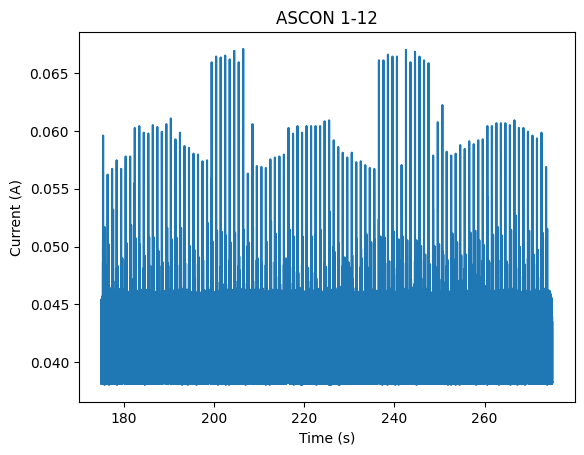

In [14]:
segments[1].plot(
    x="Timestamp",
    y="Value",
    title="ASCON 1-12",
    xlabel="Time (s)",
    ylabel="Current (A)",
    legend=False,
)